In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import lightning as L
import lightning.pytorch as pl
import sys
import os

sys.path.append("..")
from scripts.make_dataloader import AnomalyDataLoader, NormalDataLoader, TestingDataLoader
from models.classifier_model import Classifier
from scripts.train_classifier import LitClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from rich.progress import Progress, TextColumn, MofNCompleteColumn, TimeElapsedColumn, TimeRemainingColumn, BarColumn
from copy import deepcopy
from collections import defaultdict

In [2]:
df_train = pd.read_csv("/media/darthvader/New Volume/DataHub/infosys/chest_xray/train_val_df.csv")
df_test = pd.read_csv("/media/darthvader/New Volume/DataHub/infosys/chest_xray/test_df.csv")

print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the test data: {df_test.shape}")

Shape of the training data: (73471, 8)
Shape of the test data: (17914, 8)


# Anomaly Detection

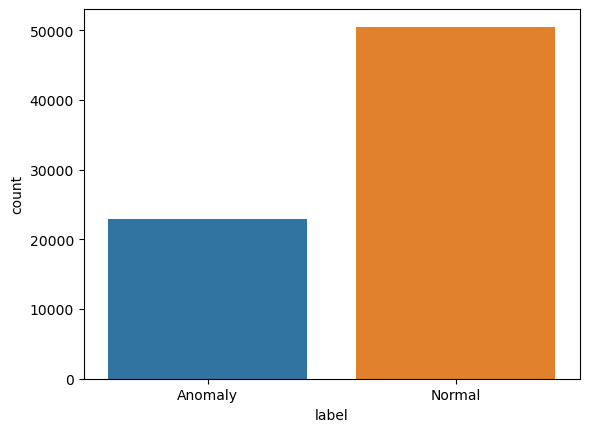

In [3]:
df_train["label"] = df_train["label"].apply(lambda x: "Normal" if x == "No Finding" else "Anomaly")
sns.countplot(x="label", data=df_train)
plt.show()

## Create dataloader for the Anomaly Model

In [26]:
model = Classifier(n_classes=2)
lit_model = LitClassifier.load_from_checkpoint("../checkpoints/anomaly_binary_classifier-v4.ckpt", model=model, as_anomaly=False)
lit_model

LitClassifier(
  (classifier): Classifier(
    (model): Sequential(
      (conv1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (layer_1): ResidualBlocks(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      )
      (layer_2): ResidualBlocks(
        (conv1): Conv2

In [27]:
transformations = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(.5,), std=(.5,))
])

## Testing Anomaly Detection Algorithm

In [28]:
df_anomaly_detection = deepcopy(df_test)
df_anomaly_detection["label"] = df_anomaly_detection["label"].apply(lambda x: "Normal" if x == "No Finding" else "Anomaly")

In [29]:
anomaly_LABEL_MAP = {"Normal":0, "Anomaly": 1}
anomaly_detection_obj = TestingDataLoader(label_map=anomaly_LABEL_MAP, batch_size=32)
anomaly_detection_obj.setup(df_anomaly_detection, transformations=transformations)

test_anomaly_detect_ds, test_anomaly_detect_dl = anomaly_detection_obj.get_test()

In [30]:
for batch in test_anomaly_detect_dl:
    print(batch["img"].size(), batch["label"].size())
    break

torch.Size([32, 1, 224, 224]) torch.Size([32])


In [31]:
prog_bar = Progress(
    TextColumn("[progress.percentage] {task.description}"),
    BarColumn(),
    MofNCompleteColumn(),
    TextColumn("•"),
    TimeElapsedColumn(),
    TextColumn("•"),
    TimeRemainingColumn()
)



labels = list()
scores = list()

with prog_bar as p:
    with torch.no_grad():
        lit_model.classifier.eval()

        for batch in p.track(test_anomaly_detect_dl, description="Testing Anomaly Detector"):

            img = batch["img"].to("cuda:0")
            label = batch["label"]
            yhat = F.sigmoid(lit_model.classifier(img))
            scores.append(yhat.detach().cpu().numpy())
            labels.append(label)

Output()

In [32]:
scores_arr = np.concatenate(scores, axis=0)
labels_arr = np.concatenate(labels, axis=0)

In [33]:
confusion_matrix(labels_arr, np.argmax(scores_arr, axis=1), labels=np.array([0, 1]))

array([[7232, 2680],
       [4405, 3597]])

In [34]:
recall_score(labels_arr, np.argmax(scores_arr, axis=1), average="micro")

0.604499274310595